Задача: https://boosters.pro/championship/rsc_sandbox/overview

Итоговый скор: 0.80754

# Preparation

Подключим гугл диск

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Разархивируем архив

In [ ]:
!unzip -q "/content/drive/MyDrive/Colab Notebooks/rosneft/train.zip"
!unzip -q "/content/drive/MyDrive/Colab Notebooks/rosneft/test.zip" -d "/content/test/"

Импорт библиотек

In [ ]:
import os
import albumentations as A
from albumentations.pytorch import ToTensor
import tqdm
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.optim import Adam
from torchvision.models import resnet34

Пропишем пути

In [ ]:
NUM_EPOCHS = 80

IMAGE_PATH = '/content/stg2_train_images_new/'
MASK_PATH = '/content/drive/MyDrive/Colab Notebooks/rosneft/train.csv'
TEST_PATH = '/content/test/images_new/'
SAMPLE_PATH = '/content/drive/MyDrive/Colab Notebooks/rosneft/submission.csv'
device = torch.device('cuda')
# device = torch.device('cpu')

In [ ]:
csv_ = pd.read_csv(MASK_PATH)
print(csv_.head())
print(len(csv_))
# print(csv_['ClassId'].max())
# print(csv_['ClassId'].min())

           ImageId  ClassId                                      EncodedPixels
0  inline_1400.png        0  95 94 479 94 863 94 1247 94 1631 94 2015 94 23...
1  inline_1400.png        1  189 6 573 6 957 6 1341 6 1725 6 2109 6 2493 6 ...
2  inline_1400.png        2  195 12 579 12 963 12 1347 12 1731 12 2115 12 2...
3  inline_1400.png        3  207 1 591 1 975 1 1359 1 1743 1 2127 1 2511 1 ...
4  inline_1400.png        4  208 15 592 15 976 15 1360 15 1744 15 2128 15 2...
168


# Model

In [ ]:
# upsampling block
class CDBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel=4, padding=1, stride=2):
        super(CDBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2),
            # nn.ConvTranspose2d(out_ch, out_ch, kernel_size=kernel, stride=stride, padding=padding, bias=False),
            # nn.BatchNorm2d(out_ch),
            # nn.LeakyReLU(0.2),
        )
        
    def forward(self, x):
        x = F.interpolate(x, scale_factor=2)
        return self.block(x)


# shape test
# model = CDBlock(in_ch=64, out_ch=32)
# x = torch.randn((8, 64, 192, 192))
# print(model(x).shape)

torch.Size([8, 32, 384, 384])


In [ ]:
# downsampling block
class CBlock(nn.Module):
    def __init__(self, in_ch, out_ch, stride=2):
        super(CBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2),
            nn.Conv2d(out_ch, out_ch, kernel_size=4, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2),
        )
        
    def forward(self, x):
        return self.block(x)


# upsampling block
class CDBlock(nn.Module):
    def __init__(self, in_ch, out_ch, kernel=4, padding=1, stride=2):
        super(CDBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2),
        )

        self.pit = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(out_ch, out_ch, kernel_size=kernel, stride=stride, padding=padding, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.LeakyReLU(0.2),
        )
        
    def forward(self, x):
        if x.shape[-1] == 1:
            return self.pit(x)
        else:
            x = F.interpolate(x, scale_factor=2)
            return self.block(x)

    
class UnetSegmenter(nn.Module):
    def __init__(self, d=64, num_classes=8):
        super(UnetSegmenter, self).__init__()
        # encoder
        # input dim = 384x384
        self.down1 = nn.Sequential(
            nn.Conv2d(3, d, 4, 2, 1),
            nn.LeakyReLU(0.2),
        )
        # 192x192
        self.down2 = CBlock(d, d*2)
        # 96x96
        self.down3 = CBlock(d*2, d*4)
        # 48x48
        self.down4 = CBlock(d*4, d*8)
        # 24x24
        self.down5 = CBlock(d*8, d*8)
        # 12x12
        self.down6 = CBlock(d*8, d*8)
        # 6x6
        self.down7 = CBlock(d*8, d*8)
        # 3x3
        self.down8 = nn.Sequential(
            nn.Conv2d(d*8, d*8, 4, 2, 1), nn.ReLU()
        )

        # decoder
        # 1x1
        self.up1 = CDBlock(d*8, d*8, kernel=3, padding=0)
        # 3x3
        self.up2 = CDBlock(d*8*2, d*8)
        # 12x12
        self.up3 = CDBlock(d*8*2, d*8)
        # 24x24
        self.up4 = CDBlock(d*8*2, d*8)
        # 48x48
        self.up5 = CDBlock(d*8*2, d*4)
        # 96x96
        self.up6 = CDBlock(d*4*2, d*2)
        # 192x192
        self.up7 = CDBlock(d*2*2, d)
        # 384x384
        self.up8 = nn.ConvTranspose2d(d*2, num_classes, 4, 2, 1) 
        
    def forward(self, x):
        # downsample
        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        
        # upsample
        u1 = self.up1(d8)
        u2 = self.up2(torch.cat([u1, d7], 1))
        u3 = self.up3(torch.cat([u2, d6], 1))
        u4 = self.up4(torch.cat([u3, d5], 1))
        u5 = self.up5(torch.cat([u4, d4], 1))
        u6 = self.up6(torch.cat([u5, d3], 1))
        u7 = self.up7(torch.cat([u6, d2], 1))
        u8 = self.up8(torch.cat([u7, d1], 1))
        
        return u8


# model shape test
# x = torch.randn(8, 3, 384, 384)
# model = UnetSegmenter()
# print(model(x).shape)

torch.Size([8, 8, 384, 384])


# CrossEntropyLoss and MultiDice

In [ ]:
# функция потерь
class CrossEntropyLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(CrossEntropyLoss, self).__init__()
        self.loss = nn.CrossEntropyLoss(weight, size_average)

    def forward(self, logits, targets):
        targets = targets.type(torch.cuda.LongTensor)
        return self.loss(logits, targets)


# метрика MultiDice 
class MultiDice(nn.Module):
    """
    Calculate Dice with averaging per classes and then per batch 
    """
    def __init__(self, num_classes=8):
        super(MultiDice, self).__init__()
        self.num_classes = num_classes

    def forward(self, outputs, targets):
        smooth = 1e-15
        prediction = outputs.softmax(dim=1)
        
        dices = []
        
        for val in range(1, self.num_classes):
            target = (targets == val).float().squeeze()
            ch_pred = prediction[:, val]
            intersection = torch.sum(ch_pred * target, dim=(1,2))
            # вот тут поправил, а то у меня ломалось, если полный батч не набирается :)
            # вроде ничего не сломал))
            try:
                union = torch.sum(ch_pred, dim=(1,2)) + torch.sum(target, dim=(1,2))   
            except:
                union = torch.sum(ch_pred) + torch.sum(target)
            dice_part = (2 * intersection + smooth) / (union + smooth)
        dices.append(dice_part.mean())
        return torch.mean(dice_part)

In [ ]:
# перевод rle в маску
def rle2mask(mask_rle, shape):
    """
    mask_rle: run-length as string formated (start length)ы
    shape: (width,height) of array to return
    Returns numpy array, 1 - mask, 0 - background
    """
    if mask_rle != mask_rle:
        return np.zeros_like(shape)

    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

# Dataset

In [ ]:
class TrainDataset():
    def __init__(self, image_dir, train, transform):
        self.image_dir = image_dir
        self.train = train
        self.transform = transform

    def __getitem__(self, index):
        # получили имя картинки по индексу
        img_name = self.train.iloc[index]['ImageId']
        
        # считали картинку
        path = os.path.join(self.image_dir, img_name)
        img = cv2.imread(path)
        
        # перевод rle в маску картинки
        ce_mask = [
            (i + 1) * rle2mask(rle, shape=(img.shape[1], img.shape[0])) \
                for i, rle in enumerate(self.train[self.train['ImageId']==img_name]['EncodedPixels'])
        ]
        ce_mask = np.sum(ce_mask, axis=0, dtype=np.float32)

        result = self.transform(
            image=img, 
            mask=ce_mask
        )
        
        result = {
            'image': ToTensor()(image=result['image'])['image'], 
            'mask': torch.Tensor(result['mask'])
        }
        return result
    
    def __len__(self, ):
        return len(self.train)
    
class TestDataset():
    def __init__(self, image_dir, test, transform):
        self.image_dir = image_dir
        self.test = test
        self.transform = transform

    def __getitem__(self, index):
        # получили имя картинки по индексу
        img_name = self.test.iloc[index]['ImageId']
        
        # считали картинку
        path = os.path.join(self.image_dir, img_name)
        img = cv2.imread(path)

        result = self.transform(
            image=img, 
        )
        
        result = {
            'image_name': img_name,
            'image': ToTensor()(image=result['image'])['image'], 
        }
        return result
    
    def __len__(self, ):
        return len(self.test)

# Utils

In [ ]:
# сохранение чекпойнта
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"):
    print("=> Saving checkpoint")
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)


# загрузка чекпойнта
def load_checkpoint(checkpoint_file, model, optimizer):
    print("=> Loading checkpoint")
    checkpoint = torch.load(checkpoint_file, map_location=device)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])


# перевод маски в rle
def mask2rle(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


# перевод выхода модели в rle
def out2rle(outputs, i):
    rles = []
    im_names = []
    classes = []
    
    smooth = 1e-15
    prediction = outputs.detach().cpu().softmax(dim=1).numpy()

    for j, sample in enumerate(prediction):
        for val in range(1, 8):
            ch_pred = sample[val]
            shape = shapes[img_names[8*i+j]]
            ch_pred = cv2.resize(ch_pred, (shape[1], shape[0]))
            rles.append(mask2rle(ch_pred.T > 0.5))
            classes.append(val-1)
            im_names.append(img_names[8*i+j])
    return im_names, classes, rles

Трансформы и обнуление весов (для фолдов)

In [ ]:
train_transforms = A.Compose([
    A.Resize(384, 384),
    A.HorizontalFlip(p=0.5),
    A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)),
])

valid_transforms = A.Compose([
    A.Resize(384, 384),                      
    A.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)),
])

def reset_weights(m):
    '''
      Try resetting model weights to avoid
      weight leakage.
    '''
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            # print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()

# Train

In [ ]:
dataset = pd.read_csv(MASK_PATH)
dataset = TrainDataset(
    image_dir=IMAGE_PATH, 
    train=dataset, 
    transform=train_transforms
)

criterion = CrossEntropyLoss()
metric = MultiDice()

/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


## Folds

In [ ]:
Folds_train_dices = []
Folds_train_losses = []

Folds_val_dices = []
Folds_val_losses = []

# Define the K-fold Cross Validator
k_folds = 4
kfold = KFold(n_splits=k_folds, shuffle=True)

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):
    
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    train_loader = DataLoader(
        dataset=dataset,
        batch_size=8, 
        sampler=train_subsampler
    )

    valid_loader = DataLoader(
        dataset=dataset,
        batch_size=8,    
        sampler=test_subsampler
    )

    # определим модель
    model = UnetSegmenter()
    model.apply(reset_weights)
    model = nn.DataParallel(model).to(device)
    optimizer = Adam(model.parameters(), lr=0.005)

    all_train_DICE = []
    all_train_losses = []

    all_val_DICE = []
    all_val_losses = []

    # train and valid
    for epoch in tqdm.tqdm_notebook(range(NUM_EPOCHS)):
        
        # train
        model.train()
        DICE_values = []
        losses = []
        for i, data in enumerate(train_loader):
            inputs = Variable(data['image']).to(device)
            masks = Variable(data['mask']).to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, masks)
            metric_value = metric(outputs, masks) 
            
            loss.backward()
            optimizer.step()

            DICE_values.append(metric_value.item())
            losses.append(loss.item())

        all_train_DICE.append(np.mean(DICE_values))
        all_train_losses.append(np.mean(losses))
            
        # valid
        model.eval()
        DICE_values = []
        losses = []
        for i, data in enumerate(valid_loader):
            inputs = Variable(data['image']).to(device)
            masks = Variable(data['mask']).to(device)

            outputs = model(inputs)
            loss = criterion(outputs, masks)
            metric_value = metric(outputs, masks) 
            
            DICE_values.append(metric_value.item())
            losses.append(loss.item())

        all_val_DICE.append(np.mean(DICE_values))
        all_val_losses.append(np.mean(losses))

        # if (epoch+1)%5 == 0:
        #     save_checkpoint(model, optimizer, f"/content/drive/MyDrive/Colab Notebooks/rosneft/model_{fold}_{epoch}")

    Folds_train_dices.append(all_train_DICE)
    Folds_train_losses.append(all_train_losses)
    Folds_val_dices.append(all_val_DICE)
    Folds_val_losses.append(all_val_losses)

## Folds visualization

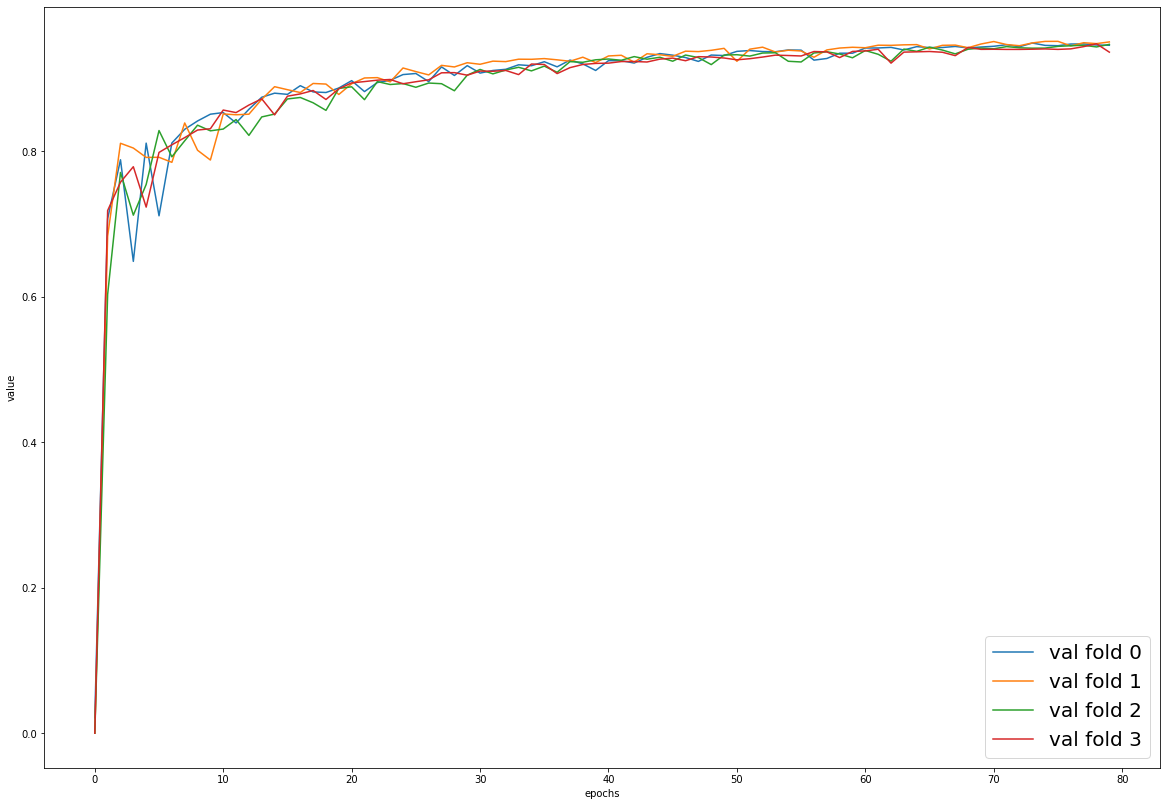

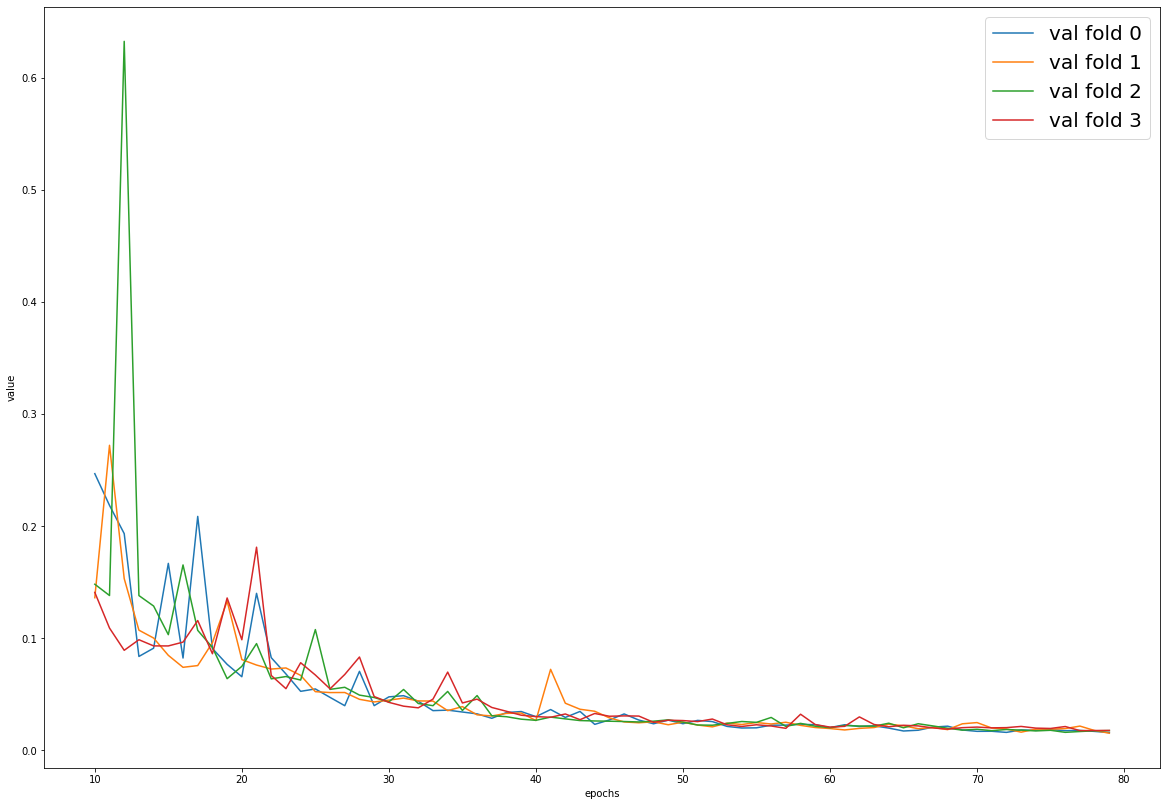

In [ ]:
plt.figure(figsize=(20, 14))
for fold in range(k_folds):
    # plt.plot(Folds_train_dices[fold], label=f'train fold {fold}')
    plt.plot(Folds_val_dices[fold], label=f'val fold {fold}')
plt.title = 'DICE'
plt.legend(fontsize=20)
plt.xlabel('epochs') 
plt.ylabel('value') 
plt.show()

plt.figure(figsize=(20, 14))
for fold in range(k_folds):
    # plt.plot(Folds_train_losses[fold], label=f'train fold {fold}')
    plt.plot(np.arange(10, NUM_EPOCHS, 1), Folds_val_losses[fold][10:], label=f'val fold {fold}')
plt.title = 'Loss'
plt.legend(fontsize=20)
plt.xlabel('epochs') 
plt.ylabel('value') 
plt.show()

# Train with whole dataset

Попробуем просто обучить модель на всех данных на 80 эпох. Судя по фолдам, не сказать, что началось переобучение. Думаю, если обучать на столько же эпох с большим кол-вом данных переобучение тоже не произойдет :)

In [ ]:
train_loader = DataLoader(
        dataset=dataset,
        batch_size=8, 
        shuffle=True
    )

# определим модель
model = UnetSegmenter()
model = nn.DataParallel(model).to(device)
optimizer = Adam(model.parameters(), lr=0.005)

In [ ]:
all_train_DICE = []
all_train_losses = []

# train
for epoch in tqdm.tqdm_notebook(range(NUM_EPOCHS)):
    
    # train
    model.train()
    DICE_values = []
    losses = []
    for i, data in enumerate(train_loader):
        inputs = Variable(data['image']).to(device)
        masks = Variable(data['mask']).to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, masks)
        metric_value = metric(outputs, masks) 
        
        loss.backward()
        optimizer.step()

        DICE_values.append(metric_value.item())
        losses.append(loss.item())

    all_train_DICE.append(np.mean(DICE_values))
    all_train_losses.append(np.mean(losses))

    if (epoch+1)%10 == 0:
        save_checkpoint(model, optimizer, f"/content/drive/MyDrive/Colab Notebooks/rosneft/model_{epoch}")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/80 [00:00<?, ?it/s]

=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint
=> Saving checkpoint


# Submission

In [ ]:
# load_checkpoint("/content/drive/MyDrive/Colab Notebooks/rosneft/model", model, optimizer)

=> Loading checkpoint


In [ ]:
# test = pd.read_csv(SAMPLE_PATH)
# test_ids = test.drop_duplicates('ImageId')
test = pd.DataFrame(columns=['ImageId', 'ClassId', 'EncodedPixels'])
test['ImageId'] = list(os.listdir(TEST_PATH))
test_ids = test['ImageId']

In [ ]:
test_dataset = TestDataset(
    image_dir=TEST_PATH, 
    test=test, 
    transform=valid_transforms
)

In [ ]:
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=8,                
    shuffle=False, 
)

Сделаем словарь (название картинки: размерность картинки), чтобы после предсказания можно было вернуть картинку в ее первоначальную размерность

In [ ]:
img_names = test.ImageId.values
shapes = {name: cv2.imread(os.path.join(TEST_PATH, name), 0).shape for name in img_names}
print(shapes)

{'xline_2338.png': (384, 847), 'inline_3108.png': (384, 1352), 'inline_3632.png': (384, 425), 'xline_2346.png': (384, 847), 'inline_2049.png': (384, 1066), 'inline_1724.png': (384, 1040), 'xline_1795.png': (384, 1551), 'inline_1508.png': (384, 768), 'inline_3225.png': (384, 968), 'inline_995.png': (384, 672), 'inline_2503.png': (384, 1656), 'xline_1462.png': (384, 1888), 'xline_568.png': (384, 760), 'inline_3568.png': (384, 936), 'inline_3009.png': (384, 1512), 'inline_2658.png': (384, 1608), 'inline_3030.png': (384, 1504), 'inline_1275.png': (384, 768), 'inline_1750.png': (384, 1040), 'inline_1530.png': (384, 768), 'xline_648.png': (384, 1042), 'inline_2099.png': (384, 1128), 'inline_3064.png': (384, 1496), 'inline_2819.png': (384, 1560), 'inline_3483.png': (384, 968), 'xline_1917.png': (384, 1519), 'inline_1153.png': (384, 768), 'inline_1880.png': (384, 1024), 'xline_1114.png': (384, 2710), 'xline_729.png': (384, 1590), 'xline_1880.png': (384, 1527), 'inline_1143.png': (384, 768), 'i

In [ ]:
all_names = []
all_classes = []
all_rles = []

for i, data in tqdm.tqdm_notebook(enumerate(test_loader), total=len(test_loader)):
    inputs = Variable(data['image']).to(device)
    outputs = model(inputs)
    
    out = out2rle(outputs, i)
    all_names += out[0]
    all_classes += out[1]
    all_rles += out[2]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """


  0%|          | 0/344 [00:00<?, ?it/s]

In [ ]:
print(len(all_names))
print(len(all_classes))
print(len(all_rles))

19257
19257
19257


In [ ]:
submission = pd.DataFrame(columns=['ImageId', 'ClassId', 'EncodedPixels'])
submission['ImageId'] = all_names
submission['ClassId'] = all_classes
submission['EncodedPixels'] = all_rles
submission = submission.sort_values(by=['ImageId', 'ClassId'])
submission.to_csv('/content/drive/MyDrive/Colab Notebooks/rosneft/submission.csv', index=False)
print(submission.head())
print(len(submission))

              ImageId  ClassId  \
1008  inline_1002.png        0   
1009  inline_1002.png        1   
1010  inline_1002.png        2   
1011  inline_1002.png        3   
1012  inline_1002.png        4   

                                          EncodedPixels  
1008  96 95 480 95 864 95 1248 95 1632 95 2016 94 24...  
1009  191 4 575 4 959 5 1343 4 1727 4 2110 5 2494 5 ...  
1010  195 14 579 14 964 13 1347 14 1731 14 2115 14 2...  
1011  977 1 1361 1 1745 1 2129 1 2513 1 2897 1 3281 ...  
1012  210 20 594 20 978 20 1362 20 1746 20 2130 20 2...  
19257
